In [10]:
import pandas as pd
import numpy as np

from sklearn.compose import  ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet

from jcopml.plot import plot_missing_value, plot_residual, plot_actual_vs_prediction
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp
from jcopml.feature_importance import mean_score_decrease
from jcopml.pipeline import num_pipe, cat_pipe 

In [2]:
data = pd.read_csv('E:\Data Science\Python\machine learning exercises\dataset\\taxi_fare.csv', parse_dates=['pickup_datetime'])

data.dropna(inplace=True)
pickup_dt = data.pickup_datetime.dt

data['year'] = pickup_dt.year
data['month'] = pickup_dt.month
data['day'] = pickup_dt.day_of_week
data['hour'] = pickup_dt.hour

data['distance'] =  np.abs(data.pickup_latitude - data.dropoff_latitude) + np.abs(data.pickup_longitude - data.dropoff_longitude)
data.drop(labels=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime'], axis=1, inplace=True)
data

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194
...,...,...,...,...,...,...,...
18913,9.5,1.0,2013,3,1,7,0.032231
18914,22.5,2.0,2013,6,6,1,0.099069
18915,5.5,1.0,2014,10,2,14,0.014168
18916,6.5,1.0,2015,6,6,13,0.015774


### Dataset Splitting

In [3]:
X = data.drop('fare_amount', axis=1)
y = data.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [5]:
rsp.enet_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [9]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'distance', 'year']),
    ('categoric', cat_pipe(encoder='onehot'), ['day', 'month', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(estimator=pipeline, cv=3, n_jobs=-1, verbose=1, param_distributions=rsp.enet_poly_params, n_iter=50)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.best_score_, model.score(X_train,  y_train), model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__alpha': 0.0006471863920551658, 'algo__fit_intercept': False, 'algo__l1_ratio': 0.27732614936266636, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7055398846579012 0.7087945937024149 0.7351503048354522


c:\Users\09021\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+05, tolerance: 3.344e+02
  model = cd_fast.enet_coordinate_descent(


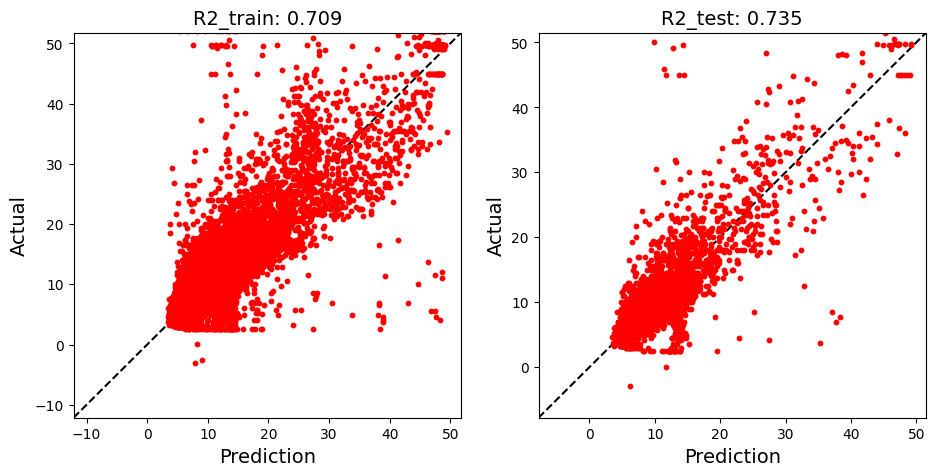

In [11]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

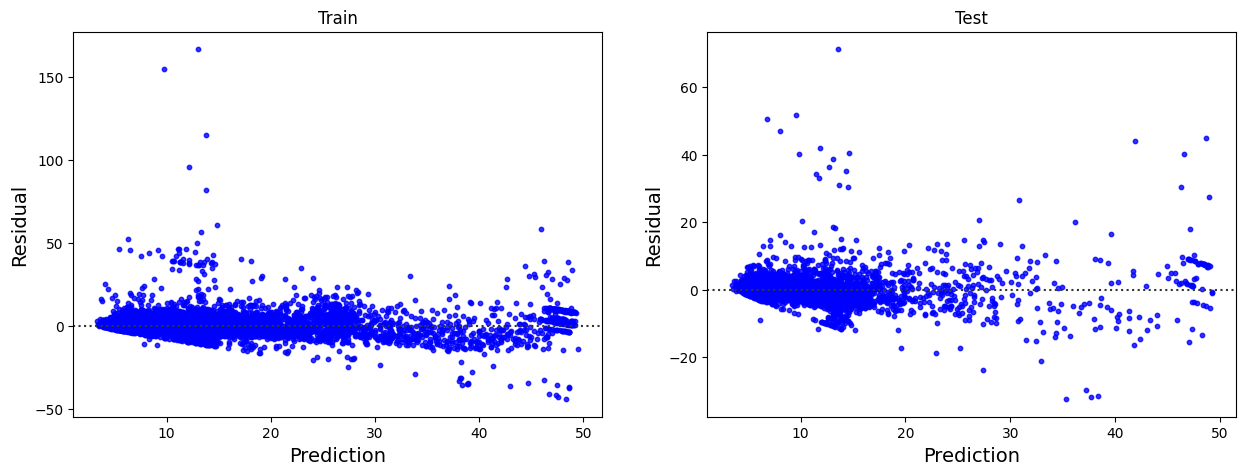

In [12]:
plot_residual(X_train, y_train, X_test, y_test, model)

## Feature Importance

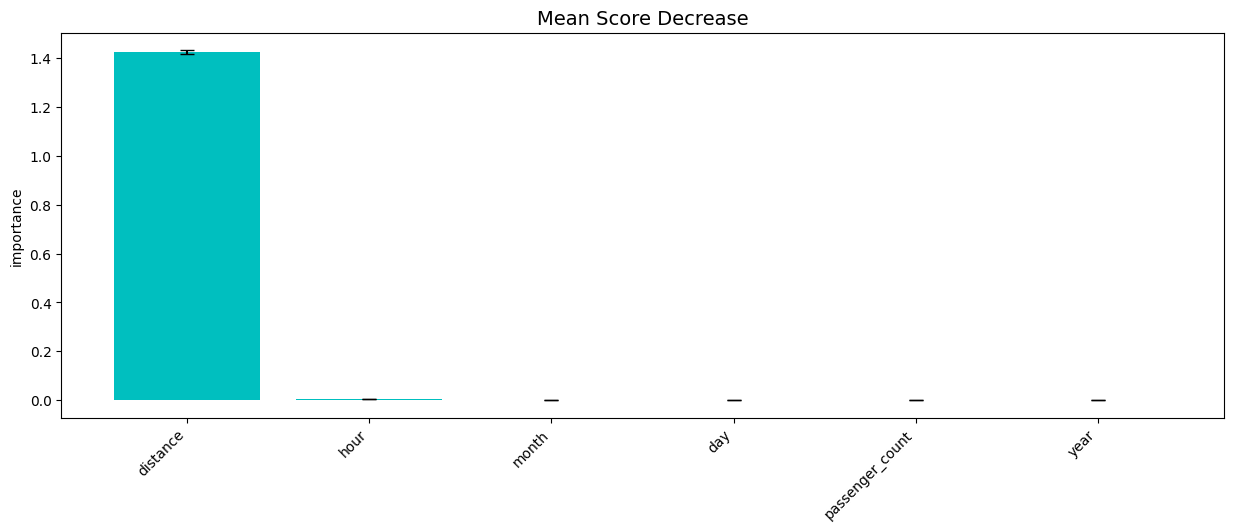

In [14]:
df_importance = mean_score_decrease(X_train, y_train, model, plot=True)

### Error Analysis

- Dari hasil residual plot, masih terdapat imbalance pada data. Yaitu model masih gagal menangkap pola dari beberapa data seperti pada saat x = 10 dan x = 50 model belum bisa menangkap pola dari data (Kesalahannya masih besar)

In [16]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error

df_analysis.sort_values('error', ascending=False).head(20)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.994193
1483,1.0,2009,8,4,21,0.000416,165.00,155.249542
6630,1.0,2014,5,4,1,0.000000,128.83,115.070893
14142,1.0,2014,12,4,10,0.045860,108.00,95.851591
12915,1.0,2011,9,2,1,0.000000,96.00,82.219437
10524,1.0,2010,5,1,14,0.000000,75.80,60.966093
12349,1.0,2010,5,5,15,0.434492,104.67,58.687081
1494,1.0,2009,9,1,14,0.000031,70.00,56.721492
2432,1.0,2012,11,4,1,0.003817,58.60,52.326668
2346,1.0,2009,2,5,0,0.000000,63.00,50.109383


### Drop Data with Distance = 0

In [25]:
data = data[~(data.distance == 0)]

### Train Again

In [26]:
X = data.drop('fare_amount', axis=1)
y = data.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'distance', 'year']),
    ('categoric', cat_pipe(encoder='onehot'), ['day', 'month', 'hour'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model = RandomizedSearchCV(estimator=pipeline, cv=3, n_jobs=-1, verbose=1, param_distributions=rsp.enet_poly_params, n_iter=50)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.best_score_, model.score(X_train,  y_train), model.score(X_test, y_test))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__alpha': 0.00010972875762696987, 'algo__fit_intercept': False, 'algo__l1_ratio': 0.9946464148517081, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.7475480412267786 0.7498530551744039 0.7499487695420233


c:\Users\09021\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9463.372229727684, tolerance: 319.71933481
  model = cd_fast.sparse_enet_coordinate_descent(


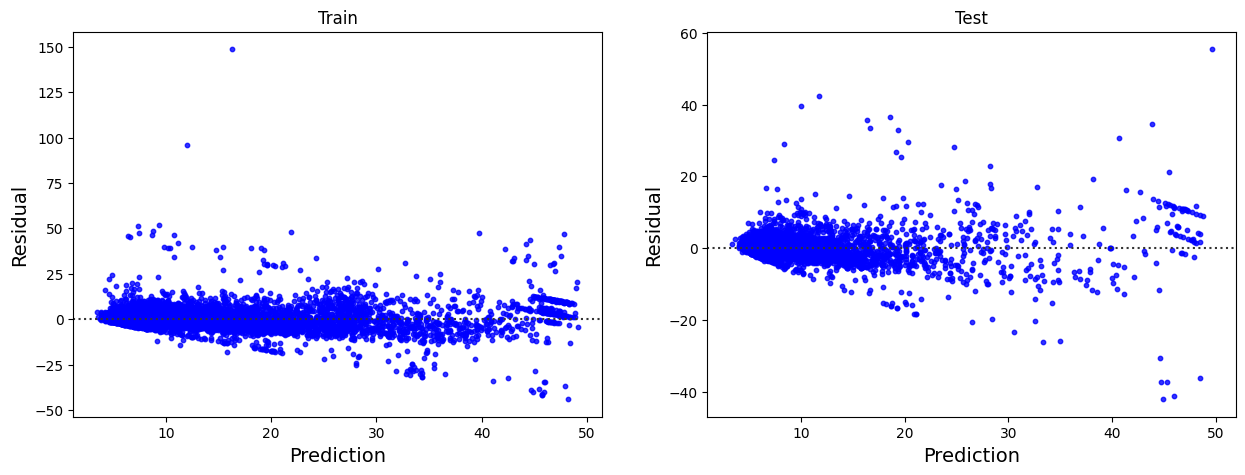

In [27]:
plot_residual(X_train, y_train, X_test, y_test, model)

### 

- Hasil residual plot sudah lumayan baik dari yang sebelumnya imbalance, namum masih terdapat sedikit kesalahan, yakni disebabkan oleh outlier